In [123]:
# Import the correct algorithm
from surprise import Dataset, Reader, accuracy, SVD, CoClustering, SlopeOne 
from surprise.accuracy import rmse
from surprise.model_selection import GridSearchCV, train_test_split
import pandas as pd
import time
import pathlib
import numpy as np
import math

## Load Datasets

In [2]:
data_100k =  Dataset.load_builtin('ml-100k')
# data_1m = Dataset.load_builtin('ml-1m')
# path = pathlib.Path('ml-10M100K').resolve() / 'ratings.dat'
# reader = Reader(line_format="user item rating timestamp",sep='::')
# print(path)
# data_10m = Dataset.load_from_file(file_path=path,reader=reader)

In [44]:
# 'user item rating timestamp', separated by '::' characters.
# reader = Reader(line_format="user item rating timestamp",sep='::')

# param_grid = {"n_epochs": [10], 
#               "lr_all": [0.002,0.003,0.005], 
#               "reg_all": [0.01,0.02,0.03],
#               'biased':[True,False],'random_state':[1],
#               'verbose':[True]}

# param_grid = {"n_cltr_u": [2,3,4], 
#               "n_cltr_i": [2,3,4], 
#               "random_state":[1],
#               "verbose":[True]}

# gs_SVD = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3, n_jobs=-1)
# gs_SlopeOne = GridSearchCV(SlopeOne, param_grid, measures=["rmse"], cv=3, n_jobs=-1)
# gs_CoClustering = GridSearchCV(CoClustering, param_grid, measures=["rmse"], cv=3, n_jobs=-1)
# gs_CoClustering.param_combinations

# gs_SVD.fit(data_100k)
# gs_SlopeOne.fit(data_100k)
# gs_CoClustering.fit(data_100k)
# print("SVD - 100k")
# print('RMSE_best_score:',gs_SVD.best_score["rmse"])
# print('RMSE_best_params',gs_SVD.best_params["rmse"])
# train_data_100k, test_data_100k = train_test_split(data_100k, test_size=0.25, random_state=1)
# algo = gs.best_estimator["rmse"]
# algo.fit(train_data_100k)

## Initialise diff algo

In [3]:
svd = SVD()
co_clustering = CoClustering()
slope_one = SlopeOne()
algo_dict = {"SVD":svd,"CoClustering":co_clustering,"SlopeOne":slope_one}

## Split training and test data

In [4]:
# Test set is 25%
train_data_100k, test_data_100k = train_test_split(data_100k, test_size=0.25, random_state=1)
# train_data_1m, test_data_1m = train_test_split(data_1m, test_size=0.25, random_state=1)
# train_data_10m, test_data_10m = train_test_split(data_10m, test_size=0.25, random_state=1)

## Compare fit timing and prediction accuracy

In [5]:
predictions = {}

print("----------- 100k ---------------")
for name,algo in algo_dict.items():
    begin = time.time()
    algo.fit(train_data_100k)
    end = time.time()
    predictions[name] = algo.test(test_data_100k)
    result = accuracy.rmse(predictions[name])
    print(f'{name}: {result}, fit_time: {round(end-begin,2)}')
    print()

# print("----------- 1m ---------------")
# for name,algo in algo_dict.items():
#     begin = time.time()
#     algo.fit(train_data_1m)
#     end = time.time()
#     predictions[name] = algo.test(test_data_1m)
#     result = accuracy.rmse(predictions[name])
#     print(f'{name}: {result}, fit_time: {round(end-begin,2)}')
#     print()

# print("----------- 10m ---------------")
# for name,algo in algo_dict.items():
#     begin = time.time()
#     algo.fit(train_data_10m)
#     end = time.time()
#     predictions[name] = algo.test(test_data_10m)
#     result = accuracy.rmse(predictions[name])
#     print(f'{name}: {result}, fit_time: {round(end-begin,2)}')
#     print()

----------- 100k ---------------
RMSE: 0.9441
SVD: 0.9440700420917433, fit_time: 0.79

RMSE: 0.9716
CoClustering: 0.9716279462341331, fit_time: 1.21

RMSE: 0.9477
SlopeOne: 0.9477498649038465, fit_time: 0.49



## Preparing dataframe for predictions

In [6]:
test_data_100k = pd.DataFrame(test_data_100k)
test_data_100k = test_data_100k.rename(columns={
    0: "uid",
    1: "iid",
    2: "rating"
})

# test_data_1m = pd.DataFrame(test_data_1m)
# test_data_1m = test_data_1m.rename(columns={
#     0: "uid",
#     1: "iid",
#     2: "rating"
# })

# test_data_10m = pd.DataFrame(test_data_10m)
# test_data_10m = test_data_10m.rename(columns={
#     0: "uid",
#     1: "iid",
#     2: "rating"
# })

## Compare time taken to predict missing data

In [7]:
pred_dict_100k={}
pred_dict_1m={}
pred_dict_10m={}


print("----------- 100k ---------------")
for name,algo in algo_dict.items():
    pred_dict_100k[name] = []
    total_time = 0.00
    for i in range(len(test_data_100k)):
        begin = time.time()
        y_pred = algo.predict(test_data_100k.loc[i]['uid'], test_data_100k.loc[i]['iid'])
        end = time.time()
        y_pred = np.array(y_pred)
        y_pred[2] = test_data_100k.loc[i]['rating']
        pred_dict_100k[name].append(y_pred)
        total_time += end-begin
    print(name)
    print(f"time taken to generate test predictions = {round(total_time, 2)} seconds")
    print()
    
# print("----------- 1m ---------------")
# for name,algo in algo_dict.items():
#     pred_dict_1m[name] = []
#     total_time = 0.00
#     for i in range(len(test_data_1m)):
#         begin = time.time()
#         y_pred = algo.predict(test_data_1m.loc[i]['uid'], test_data_1m.loc[i]['iid'])
#         end = time.time()
#         y_pred = np.array(y_pred)
#         y_pred[2] = test_data_1m.loc[i]['rating']
#         pred_dict_1m[name].append(y_pred)
#         total_time += end-begin
#     print(name)
#     print(f"time taken to generate test predictions = {round(total_time, 2)} seconds")
#     print()

    
# print("----------- 10m ---------------")
# for name,algo in algo_dict.items():
#     pred_dict_10m[name] = []
#     total_time = 0.00
#     for i in range(len(test_data_10m)):
#         begin = time.time()
#         y_pred = algo.predict(test_data_10m.loc[i]['uid'], test_data_10m.loc[i]['iid'])
#         end = time.time()
#         y_pred = np.array(y_pred)
#         y_pred[2] = test_data_10m.loc[i]['rating']
#         pred_dict_10m[name].append(y_pred)
#         total_time += end-begin
#     print(name)
#     print(f"time taken to generate test predictions = {round(total_time, 2)} seconds")
#     print()


----------- 100k ---------------
SVD
time taken to generate test predictions = 5.09 seconds

CoClustering
time taken to generate test predictions = 4.51 seconds

SlopeOne
time taken to generate test predictions = 6.93 seconds



## Analysis of prediction results

Analyse the Normalised Discounted Cumulative Gain for each clustering method. 
- 0 < NDCG < 1, higher the better
- 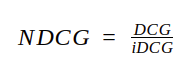

- 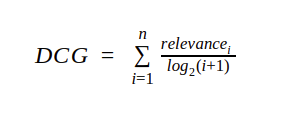
- Relevance = 0/1, 0 means that we did not predict the correct item at the correct position, 1 means that we predicted the correct item at the correct position

- iDCG is Ideal Discounted Cumulative Gain. It is calculated by assuming our N predicted recommendations follow exactly the user's top N favourites. In essence, it is the same formula as DCG but relevance = 1 for all N.

- We pick out 10 users who gave rating of 5 to less than 5 items. This is to avoid rating of 5 to overcrowd the top N recommendations.

In [141]:
# function to calculate DCG
def generateDCG(actual, pred):
    dcg = 0
    for i in range(10):
        if actual[i] == pred[i]: # whenever there is a match in the item and position, add to the dcg
            dcg += 1/math.log2(i+2)
    return dcg

# function to calculate NDCG 
def generateNDCG(data, uid):
    user = data[data['uid'] == str(uid)]
    
    actual_top10 = user.sort_values(by=['rating'], ascending = False)[:10]
    predicted_top10 = user.sort_values(by=['predicted_rating'], ascending=False)[:10]
    
    # generate idcg where all relevance = 1
    idcg = 0
    for i in range(10):
        idcg += 1/math.log2(i+2)
    
    dcg = generateDCG(actual_top10['iid'].reset_index(drop=True),
                     predicted_top10['iid'].reset_index(drop=True))
    
    return dcg / idcg

### Co-Clustering

In [148]:
# Define algo: SVD, SlopeOne, CoClustering
algo = algo_dict['CoClustering']

# converting data to dataframe so that it's easier for prediction
data_100k_df = pd.DataFrame(data_100k.__dict__['raw_ratings'], 
                            columns=['user_id','item_id','rating','timestamp'])

# generating prediction for the ENTIRE dataset which means it includes the test and train data too
all_pred_dict_100k = []
print("----------- 100k ---------------")
for i in range(len(data_100k_df)):
    y_pred = algo.predict(data_100k_df.loc[i]['user_id'], data_100k_df.loc[i]['item_id'])
    y_pred = np.array(y_pred)
    y_pred[2] = data_100k_df.loc[i]['rating']
    all_pred_dict_100k.append(y_pred)

# converting data to dataframe so that it's easier below
all_data_100k = pd.DataFrame(all_pred_dict_100k)
all_data_100k = all_data_100k.rename(columns={
    0: "uid",
    1: "iid",
    2: "rating",
    3: "predicted_rating"
})

# group the data based on user id and rating and count
# this will return the number of items a user gave a rating of {1,2,3,4,5}
grouped = data_100k_df.groupby(by=['user_id','rating']).count()

# look for potential users to do our test on
# the condition is that they have to have given less than 5 items a rating of 5
candidate_users = []
for i in range(len(data_100k_df)):
    try:
        length = grouped.loc[(str(i+1), 5)]['item_id']
        if length < 5:
            candidate_users.append(i+1)
    except:
        continue
        
# First 10 users will be used for evaluation
users = []
for i in range(10):
    users.append(candidate_users[i])

ndcg_CC = []
for i in users:
    ndcg = generateNDCG(all_data_100k, i)
    ndcg_CC.append(ndcg)
    print(f"For user {i}, NDCG = {ndcg}")

----------- 100k ---------------
For user 17, NDCG = 0.06362078819895171
For user 19, NDCG = 0.2934556883974402
For user 20, NDCG = 0.0
For user 26, NDCG = 0.22009176629808017
For user 27, NDCG = 0.0
For user 29, NDCG = 0.0
For user 32, NDCG = 0.0
For user 33, NDCG = 0.22009176629808017
For user 35, NDCG = 0.08514311764162098
For user 47, NDCG = 0.09478836436955078


### SVD

In [152]:
# Define algo: SVD, SlopeOne, CoClustering
algo = algo_dict['SVD']

# converting data to dataframe so that it's easier for prediction
data_100k_df = pd.DataFrame(data_100k.__dict__['raw_ratings'], 
                            columns=['user_id','item_id','rating','timestamp'])

# generating prediction for the ENTIRE dataset which means it includes the test and train data too
all_pred_dict_100k = []
print("----------- 100k ---------------")
for i in range(len(data_100k_df)):
    y_pred = algo.predict(data_100k_df.loc[i]['user_id'], data_100k_df.loc[i]['item_id'])
    y_pred = np.array(y_pred)
    y_pred[2] = data_100k_df.loc[i]['rating']
    all_pred_dict_100k.append(y_pred)

# converting data to dataframe so that it's easier below
all_data_100k = pd.DataFrame(all_pred_dict_100k)
all_data_100k = all_data_100k.rename(columns={
    0: "uid",
    1: "iid",
    2: "rating",
    3: "predicted_rating"
})

# group the data based on user id and rating and count
# this will return the number of items a user gave a rating of {1,2,3,4,5}
grouped = data_100k_df.groupby(by=['user_id','rating']).count()

# look for potential users to do our test on
# the condition is that they have to have given less than 5 items a rating of 5
candidate_users = []
for i in range(len(data_100k_df)):
    try:
        length = grouped.loc[(str(i+1), 5)]['item_id']
        if length < 5:
            candidate_users.append(i+1)
    except:
        continue
        
# First 10 users will be used for evaluation
users = []
for i in range(10):
    users.append(candidate_users[i])

ndcg_SVD = []
for i in users:
    ndcg = generateNDCG(all_data_100k, i)
    ndcg_SVD.append(ndcg)
    print(f"For user {i}, NDCG = {ndcg}")

----------- 100k ---------------
For user 17, NDCG = 0.22009176629808017
For user 19, NDCG = 0.0
For user 20, NDCG = 0.1731866333482261
For user 26, NDCG = 0.23365080824310533
For user 27, NDCG = 0.0
For user 29, NDCG = 0.28371255449703187
For user 32, NDCG = 0.11004588314904008
For user 33, NDCG = 0.22009176629808017
For user 35, NDCG = 0.22009176629808017
For user 47, NDCG = 0.0


### Slope One

In [149]:
# Define algo: SVD, SlopeOne, CoClustering
algo = algo_dict['SlopeOne']

# converting data to dataframe so that it's easier for prediction
data_100k_df = pd.DataFrame(data_100k.__dict__['raw_ratings'], 
                            columns=['user_id','item_id','rating','timestamp'])

# generating prediction for the ENTIRE dataset which means it includes the test and train data too
all_pred_dict_100k = []
print("----------- 100k ---------------")
for i in range(len(data_100k_df)):
    y_pred = algo.predict(data_100k_df.loc[i]['user_id'], data_100k_df.loc[i]['item_id'])
    y_pred = np.array(y_pred)
    y_pred[2] = data_100k_df.loc[i]['rating']
    all_pred_dict_100k.append(y_pred)

# converting data to dataframe so that it's easier below
all_data_100k = pd.DataFrame(all_pred_dict_100k)
all_data_100k = all_data_100k.rename(columns={
    0: "uid",
    1: "iid",
    2: "rating",
    3: "predicted_rating"
})

# group the data based on user id and rating and count
# this will return the number of items a user gave a rating of {1,2,3,4,5}
grouped = data_100k_df.groupby(by=['user_id','rating']).count()

# look for potential users to do our test on
# the condition is that they have to have given less than 5 items a rating of 5
candidate_users = []
for i in range(len(data_100k_df)):
    try:
        length = grouped.loc[(str(i+1), 5)]['item_id']
        if length < 5:
            candidate_users.append(i+1)
    except:
        continue
        
# First 10 users will be used for evaluation
users = []
for i in range(10):
    users.append(candidate_users[i])

ndcg_SlopeOne = []
for i in users:
    ndcg = generateNDCG(all_data_100k, i)
    ndcg_SlopeOne.append(ndcg)
    print(f"For user {i}, NDCG = {ndcg}")

----------- 100k ---------------
For user 17, NDCG = 0.06625422345438903
For user 19, NDCG = 0.1681522864689108
For user 20, NDCG = 0.0
For user 26, NDCG = 0.11004588314904008
For user 27, NDCG = 0.0
For user 29, NDCG = 0.0
For user 32, NDCG = 0.0
For user 33, NDCG = 0.22009176629808017
For user 35, NDCG = 0.06625422345438903
For user 47, NDCG = 0.0


In [154]:
print(f"Average Normalised Discounted Cumulative Mean for Co-Clustering: {np.mean(ndcg_CC)}")
print(f"Average Normalised Discounted Cumulative Mean for SVD: {np.mean(ndcg_SVD)}")
print(f"Average Normalised Discounted Cumulative Mean for Slope One: {np.mean(ndcg_SlopeOne)}")

Average Normalised Discounted Cumulative Mean for Co-Clustering: 0.0977191491203724
Average Normalised Discounted Cumulative Mean for SVD: 0.14608711781316436
Average Normalised Discounted Cumulative Mean for Slope One: 0.06307983828248091
